## [PredNet](https://coxlab.github.io/prednet/)

https://github.com/coxlab/prednet
https://arxiv.org/abs/1605.08104

In [1]:
%pip install matplotlib tensorflow imageio ipywidgets

Note: you may need to restart the kernel to use updated packages.


## Setup

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

import io
import imageio
from IPython.display import display
from ipywidgets import widgets, HBox

## Dataset Construction

In [3]:
# Download dataset
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
# Load the dataset
dataset = np.load(fpath)

### Data processing

In [4]:
# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)

# We'll pick out 1000 of the 10000 total examples and use those.
samples = 500
dataset = dataset[:samples, ...]

# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print(f"Training Dataset Shapes: {str(x_train.shape)}, {str(y_train.shape)}")
print(f"Validation Dataset Shapes: {str(x_val.shape)}, {str(y_val.shape)}")

Training Dataset Shapes: (450, 19, 64, 64, 1), (450, 19, 64, 64, 1)
Validation Dataset Shapes: (50, 19, 64, 64, 1), (50, 19, 64, 64, 1)


## Data Visualization

random choice: 150
Displaying frames for example 150.


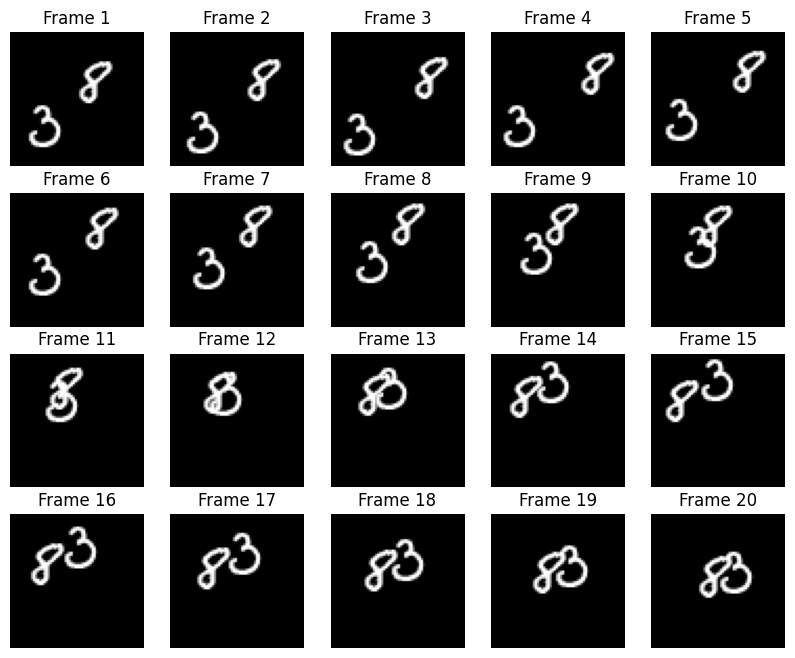

In [5]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
print(f"random choice: {data_choice}")
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

In [6]:
def create_model():
    inputs = layers.Input(shape=(None, *x_train.shape[2:]))

    # Encoding layers
    conv_1 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_2 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(conv_1)
    conv_3 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(conv_2)

    # ConvLSTM layers
    convlstm_1 = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv_3)
    convlstm_2 = layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(convlstm_1)
    convlstm_3 = layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(convlstm_2)

    # Decoding layers
    conv_4 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(convlstm_3)
    conv_5 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(conv_4)
    conv_6 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(conv_5)
    output = layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')(conv_6)
    

    # build and compile it
    # PredNet
    model = keras.models.Model(inputs, output, name="PredNet")
    model.summary()
    model.compile(
        # loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
        # for arm64
        loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.legacy.Adam(),
    )
    return model

## Model Training

In [ ]:
# Training hyperparameters
epochs = 10
batch_size = 5

model_name = f"prednet_{epochs}_{batch_size}_{samples}.h5"

if os.path.exists(f"traineds/{model_name}"):
    print(f"loading model: {model_name}")
    model = load_model(f"traineds/{model_name}")
    model.summary()
else:
    print(f"creating model: {model_name}")
    model = create_model()

    # Improve training
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

    # Fit the model to the training data
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
    )
    model.save(f"traineds/{model_name}")

creating model: prednet_10_5_500.h5
Model: "PredNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv2d (Conv2D)             (None, None, 64, 64, 16   160       
                             )                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 64, 64, 32   4640      
                             )                                   
                                                                 
 conv2d_2 (Conv2D)           (None, None, 64, 64, 64   18496     
                             )                                   
                                                                 
 conv_lstm2d (ConvLSTM2

## Frame Prediction Visualizations

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict new 10 frames
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Metrics

In [ ]:
def calculate_psnr(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    max_value = np.max(original)
    psnr = 20 * np.log10(max_value / np.sqrt(mse))
    return psnr

def calculate_mse(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    return mse

## Predicted Videos

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
psnrs = []
mses = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame
    
    # Metrics
    psnrs.append(calculate_psnr(original_frames, new_predictions))
    mses.append(calculate_mse(original_frames, new_predictions))
    

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=2)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

In [ ]:
plt.plot(psnrs)
plt.plot(mses)